# Whale Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import dill as pickle

In [3]:
PATH = './data/whale/'
arch = resnet34
sz = 224
bs = 64

In [4]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
# train_df = pd.read_csv(label_csv)
# train_df['Id'] = train_df['Id'].astype('category')
# whale_ids = train_df['Id'].unique()
# whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
# train_df['Id'] = train_df['Id'].map(whale_ids2num)
# train_df.to_csv(label_csv, index=False)
# pickle.dump(whale_ids2num, open('whale_ids2num.pkl', 'wb'))

# Data Transform

In [9]:
def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val, tfms=tfms, bs=bs)
    return data

# Find Learning Rate

In [10]:
data = get_data(sz,bs,val_idxs)

In [11]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [12]:
lrf = learn.lr_find()

 94%|█████████▎| 116/124 [01:38<00:06,  1.18it/s, loss=27.5]

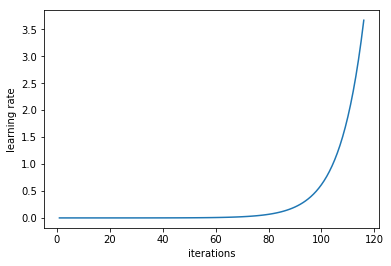

In [13]:
learn.sched.plot_lr()

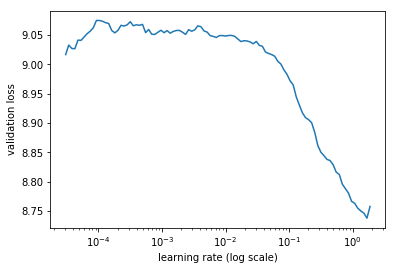

In [14]:
learn.sched.plot()

In [15]:
lr = 1e-1

In [16]:
lrs = np.array([lr/100,lr/10,lr])

# Improve Model

In [17]:
learn.fit(lr, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      8.002317   7.622395   0.079188  
    1      7.207109   7.341513   0.080711                   
    2      6.579485   7.117625   0.080203                   


[array([7.11762]), 0.0802030457230994]

In [20]:
learn.precompute = False

In [21]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.587895   7.027525   0.102538  
    1      5.341732   6.969434   0.106091                   
    2      4.940024   6.970894   0.121827                   


[array([6.97089]), 0.12182741134904967]

In [22]:
learn.save('resnet34_224_lastlayer5')

In [23]:
learn.load('resnet34_224_lastlayer5')

In [24]:
learn.unfreeze()

In [25]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      5.705513   6.852119   0.121827  
    1      5.270153   6.644525   0.133503                   
    2      4.022358   6.520443   0.167513                   
    3      4.554591   6.75958    0.143147                   
    4      3.586559   6.525508   0.196447                   
    5      2.549263   6.582887   0.239086                   
    6      1.911793   6.572498   0.237056                   


[array([6.5725]), 0.23705583753319562]

In [26]:
learn.save('resnet34_224_all5')

In [27]:
learn.load('resnet34_224_all5')

# Increase Data Image Size

In [28]:
sz = 320

In [29]:
data = get_data(sz,bs,val_idxs)
learn.set_data(data)

In [30]:
learn.freeze()

In [31]:
learn.fit(lr, 3, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   accuracy                   
    0      2.669987   6.83701    0.224365  
    1      2.448091   6.884852   0.228934                   
    2      2.24412    7.02076    0.233503                   


[array([7.02076]), 0.233502537889529]

In [32]:
learn.save('resnet34_320_last_layer5')

In [33]:
learn.load('resnet34_320_last_layer5')

In [34]:
learn.unfreeze()

In [35]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.311232   6.979986   0.243147  
    1      2.702314   6.957336   0.222335                   
    2      1.549756   6.858879   0.253807                   
    3      2.391323   7.334885   0.210152                   
    4      1.821898   7.076454   0.251269                   
    5      1.084762   7.129889   0.270558                   
    6      0.75846    7.083262   0.274112                    


[array([7.08326]), 0.27411167548997756]

In [36]:
learn.save('resnet34_320_all5')

In [47]:
learn.load('resnet34_320_all5')

# Train with Everything

In [48]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [49]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.349003   12.70225   0.0       
    1      2.195077   12.451543  0.0                        
    2      1.560761   12.437205  0.0                        
    3      1.785685   12.321591  0.0                        
    4      1.377831   13.05379   0.0                        
    5      1.045424   13.080056  0.0                        
    6      0.80351    13.160354  0.0                         


[array([13.16035]), 0.0]

# Create Submission

In [50]:
probs, _ = learn.TTA(is_test=True)

In [51]:
# Assemble our data frame
mean_probs = np.mean(probs, axis=0) # Average probs from TTA
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] # Get top 5 predictions

In [52]:
import dill as pickle
whale_ids2num = pickle.load(open('whale_ids2num.pkl', 'rb'))

In [53]:
fnames = [f[5:] for f in data.test_ds.fnames] # get rid of folder prefix

num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

In [54]:
df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('submission7b.csv', index=False)

In [ ]:
!kaggle competitions submit -c whale-categorization-playground -f submission7.csv -m "7th, transforms_side_on, training with 80% data, lr/100,lr/10,lr"

In [ ]:
!kaggle competitions submit -c whale-categorization-playground -f submission7b.csv -m "7th, transforms_side_on, training with 100% data, lr/100,lr/10,lr"

Kaggle Score: 0.39221 (7 using 80% training data) 

Kaggle Score: 0.45051 (7b using 100% training data)